# Customer Spending Prediction Model

## Data
We're going to be using a **clothing store dataset** (boutique.csv) to help the company predict how much their customers will spend with them per year.

- `gender`: self-disclosed gender identity, `male`, `female`, `nonbinary` or `other`
- `age`: current age of customer
- `height_cm`: self-reported height converted to centimeters
- `waist_size_cm`: self-reported waist size converted to centimeters
- `inseam_cm`: self-reported inseam (measurement from crotch of pants to floor) converted to centimeters
- `test_group`: whether or not the customer is in an experimental test group that gets special coupons once a month. `0` for no, `1` for yes.
- `salary_self_report_in_k`: self-reported salary of customer, in thousands
- `months_active`: number of months customer has been part of the clothing store's preferred rewards program
- `num_purchases`: the number of purchases the customer has made (a purchase is a single transaction that could include multiple items)
- `amount_spent_annual`: the average amount the customer has spent at the store per year
- `year`: the year the data was collected


# 1. Modeling

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# data imports
import pandas as pd
import numpy as np
from plotnine import *

# modeling imports
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV # Linear Regression Model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer #Z-score variables, Polynomial
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error #model evaluation
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline

In [ ]:
# load boutique data
boutique = pd.read_csv("https://raw.githubusercontent.com/katherinehansen2/CPSC392Hansen/refs/heads/main/data/boutique.csv")
boutique.head()

,year,gender,age,height_cm,waist_size_cm,inseam_cm,test_group,salary_self_report_in_k,months_active,num_purchases,amount_spent_annual
0,2020,woman,34.0,168,98,75.0,0,69.83,21,89,729.73
1,2020,man,28.0,168,88,76.0,0,61.39,7,32,621.73
2,2021,woman,18.0,170,95,75.0,0,80.55,2,25,820.82
3,2021,woman,43.0,167,97,75.0,0,82.98,4,89,880.33
4,2021,other,29.0,173,89,74.0,0,62.00,5,95,690.35


In [ ]:
# check for null values
boutique.isnull().sum()

,0
year,0
gender,0
age,20
height_cm,0
waist_size_cm,0
inseam_cm,200
test_group,0
salary_self_report_in_k,15
months_active,0
num_purchases,0


In [ ]:
# drop missing values
boutique.dropna(inplace = True)
boutique.reset_index(drop = True, inplace = True)


# separate X and Y values

# list of predictors
predictors = ["year","age","height_cm","waist_size_cm","inseam_cm", "test_group", "salary_self_report_in_k","months_active","num_purchases"]


X = boutique[predictors]
y = boutique["amount_spent_annual"]


# TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40) # 80/20


# one-hot encoding for categorical variables
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)


# z-score
scaler = StandardScaler()

X_train_2 = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) # z-score X Train
X_test_2 = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) # z-score X test using same mu and sd as train
# data leakage - make sure to tts before z score


# define model
lr = LinearRegression()


# fit the model
lr.fit(X_train_2, y_train)


# predict for both train and test sets
y_pred_train_linear = lr.predict(X_train_2)
y_pred_test_linear = lr.predict(X_test_2)

In [ ]:
# assess
print("Train MSE : ", mean_squared_error(y_train, y_pred_train_linear))
print("Train MAE : ", mean_absolute_error(y_train, y_pred_train_linear))
print("Train R2  : ", r2_score(y_train, y_pred_train_linear))
print()
print("Test MSE  : ", mean_squared_error(y_test, y_pred_test_linear))
print("Test MAE  : ", mean_absolute_error(y_test, y_pred_test_linear))
print("Test R2   : ", r2_score(y_test, y_pred_test_linear))

Train MSE :  13131.233298317511
Train MAE :  90.51830223650566
Train R2  :  0.514933078109944

Test MSE  :  13597.14259545124
Test MAE  :  91.7761564200862
Test R2   :  0.5047379222961246


In [ ]:
# polynomial regression model
n = 2
p = PolynomialFeatures(degree = n, include_bias = False)

X_train_poly = p.fit_transform(X_train_2)
X_test_poly = p.transform(X_test_2)


# define model
poly_lr = LinearRegression()


# fit the model
poly_lr.fit(X_train_poly, y_train)


# predict for both train and test sets
y_pred_train_poly = poly_lr.predict(X_train_poly)
y_pred_test_poly = poly_lr.predict(X_test_poly)


# assess
print("Train MSE : ", mean_squared_error(y_train, y_pred_train_poly))
print("Train MAE : ", mean_absolute_error(y_train, y_pred_train_poly))
print("Train R2  : ", r2_score(y_train, y_pred_train_poly))
print()
print("Test MSE  : ", mean_squared_error(y_test, y_pred_test_poly))
print("Test MAE  : ", mean_absolute_error(y_test, y_pred_test_poly))
print("Test R2   : ", r2_score(y_test, y_pred_test_poly))

Train MSE :  3350.920854898959
Train MAE :  46.256482312854864
Train R2  :  0.8762171969946421

Test MSE  :  3406.214943524059
Test MAE  :  46.457436644384835
Test R2   :  0.8759320880697339


# 2. Graphs

1. Does being in the experimental `test_group` actually increase the amount a customer spends at the store? Is this relationship different for the different genders?

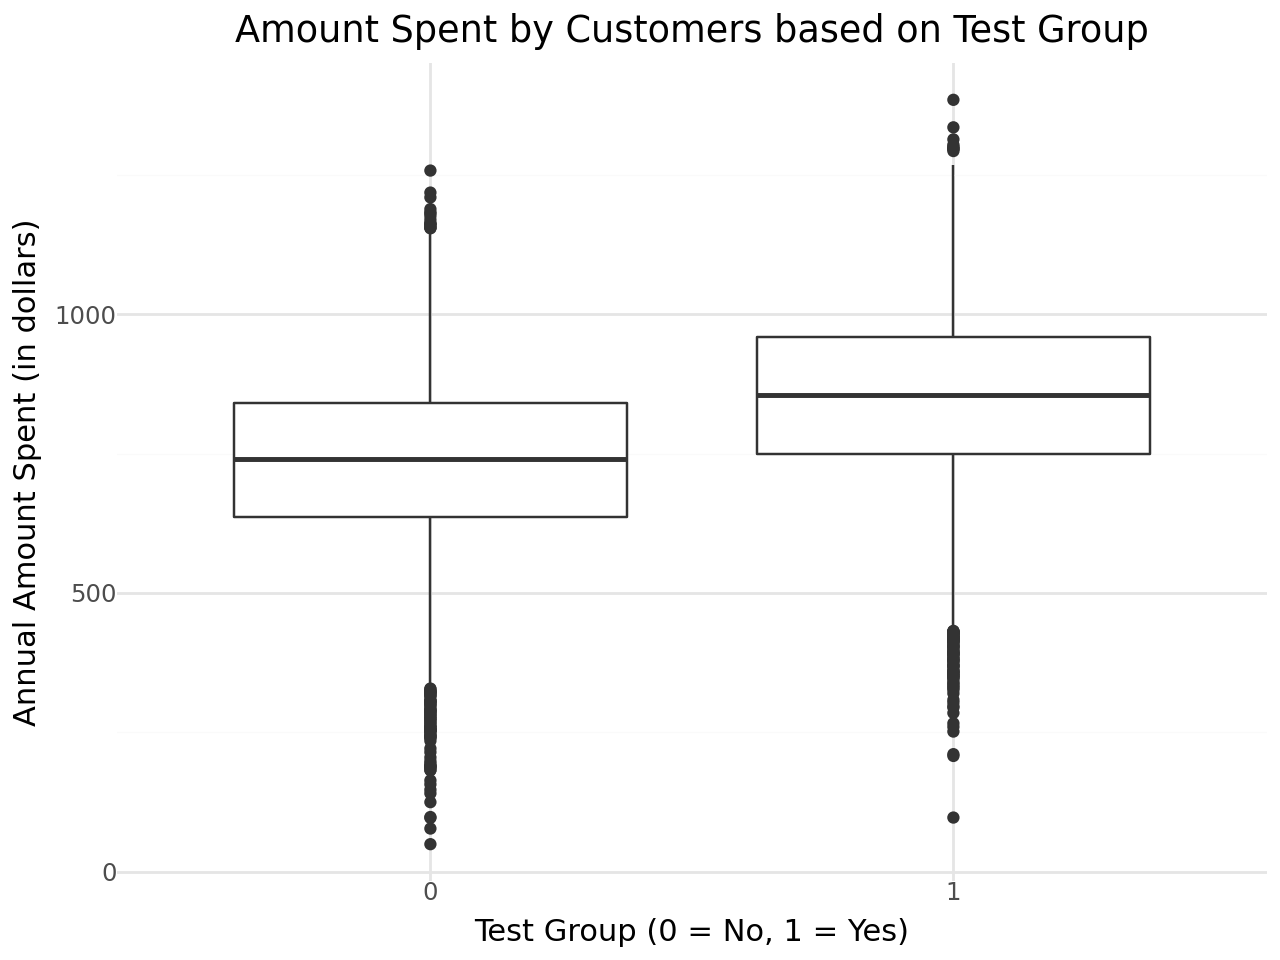

In [ ]:
boutique["test_group"] = boutique["test_group"].astype("category")

(ggplot(boutique, aes(x = "test_group", y = "amount_spent_annual"))
+ geom_boxplot()
+ labs(title = "Amount Spent by Customers based on Test Group",
       x = "Test Group (0 = No, 1 = Yes)",
       y = "Annual Amount Spent (in dollars)")
+ theme_minimal())

Looking at the box plot, it seems like people in the test group are spending more money than those who aren't. The line in the middle of the box shows the average amount spent, and in this case, the test group’s line is higher. This means that most people in the test group are buying more stuff at the store. There are also some people in the test group who spent a lot more than the average (outliers). This could mean that being part of the test group helps customers spend more money overall, so it looks like being in that group does make a difference in how much they spend.

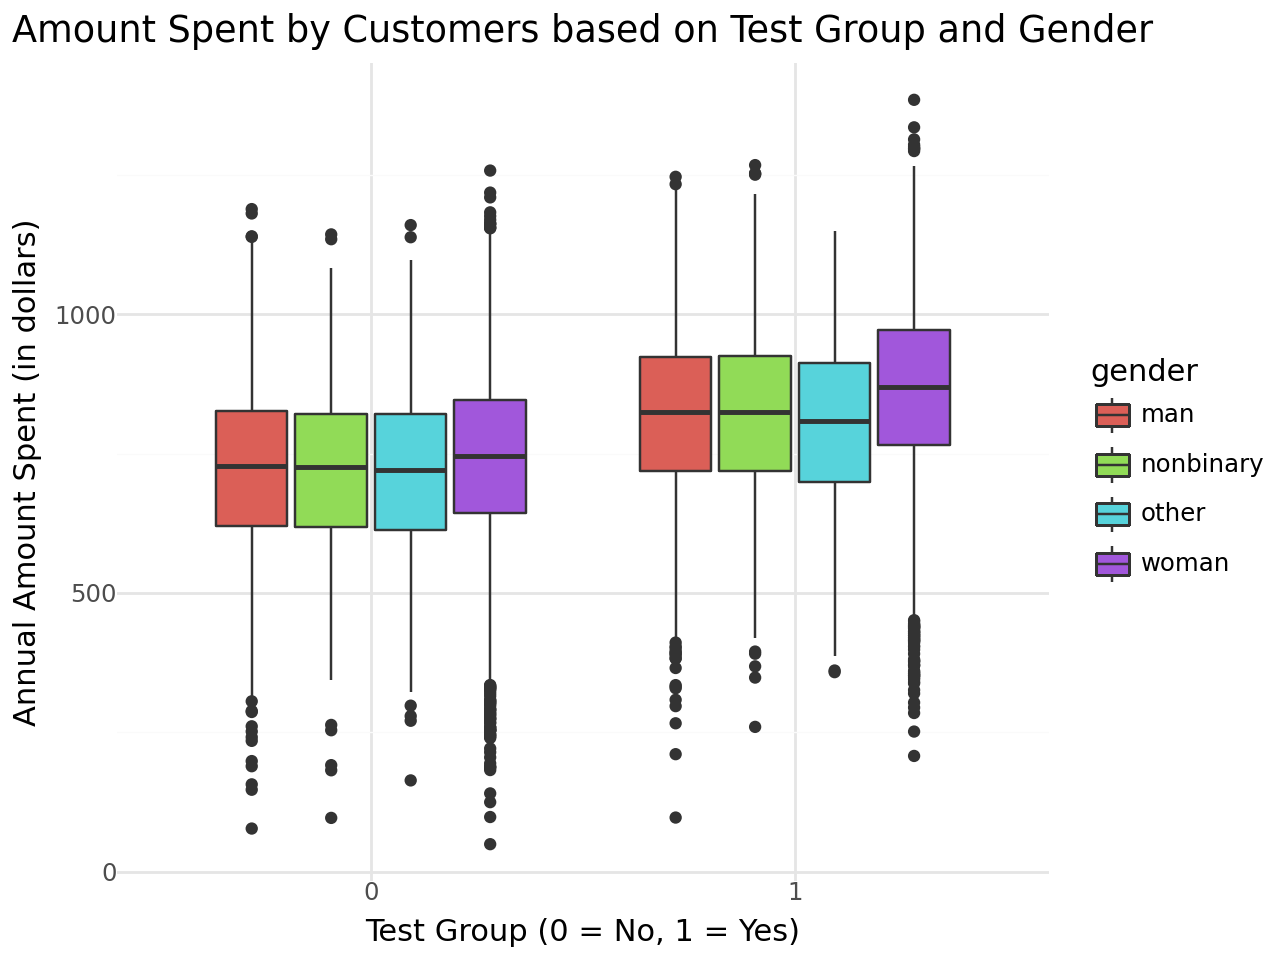

In [ ]:
boutique["test_group"] = boutique["test_group"].astype("category")

(ggplot(boutique, aes(x = "test_group", y = "amount_spent_annual", fill = "gender"))
+ geom_boxplot()
+ labs(title = "Amount Spent by Customers based on Test Group and Gender",
       x = "Test Group (0 = No, 1 = Yes)",
       y = "Annual Amount Spent (in dollars)")
+ theme_minimal())

This box plot shows how much different genders spend if they are part of the test group or not. Each color in the box plot represents a different gender, making it easier to compare. When we look closely, we can see that one gender might be spending more money than the other in both groups. Women tend to be spending more compared to the other genders (regardless if they are in the test group or not). The size of the boxes tells us how much people’s spending varies, and we can see that some groups have a bigger range, meaning some people spend a lot more than others.

5. In this dataset, is there a relationship between salary and height? Is it different for the different genders?


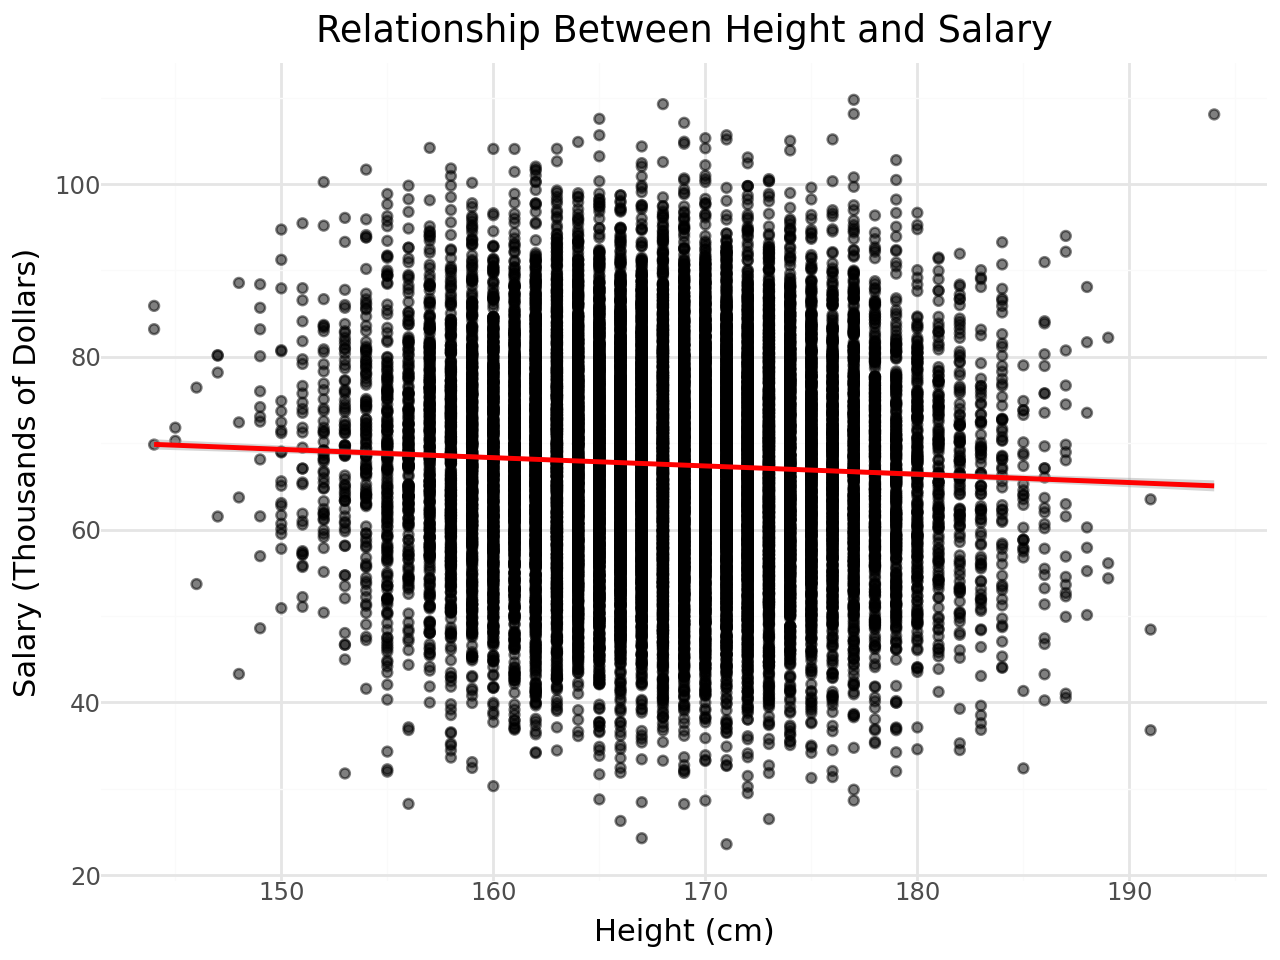

In [ ]:
(ggplot(boutique, aes(x = "height_cm", y = "salary_self_report_in_k"))
+ geom_point(alpha = 0.5)
+ labs(title = "Relationship Between Height and Salary",
       x = "Height (cm)",
       y = "Salary (Thousands of Dollars)")
+ stat_smooth(method = "lm", color = "red")
+ theme_minimal())

The first plot shows the overall relationship between salary and height for everyone in the dataset. From the graph, there is a slight negative trend, as indicated by the red line sloping downward. This suggests that as height increases, salary tends to decrease a little. However, this trend is not very strong, as the data points are scattered widely around the line. The spread of the points shows that there is a lot of variation in salary that isn’t explained by height, meaning height does not seem to have a significant impact on how much people earn. While the downward slope of the line shows a minor pattern, the relationship between height and salary is weak in this dataset.

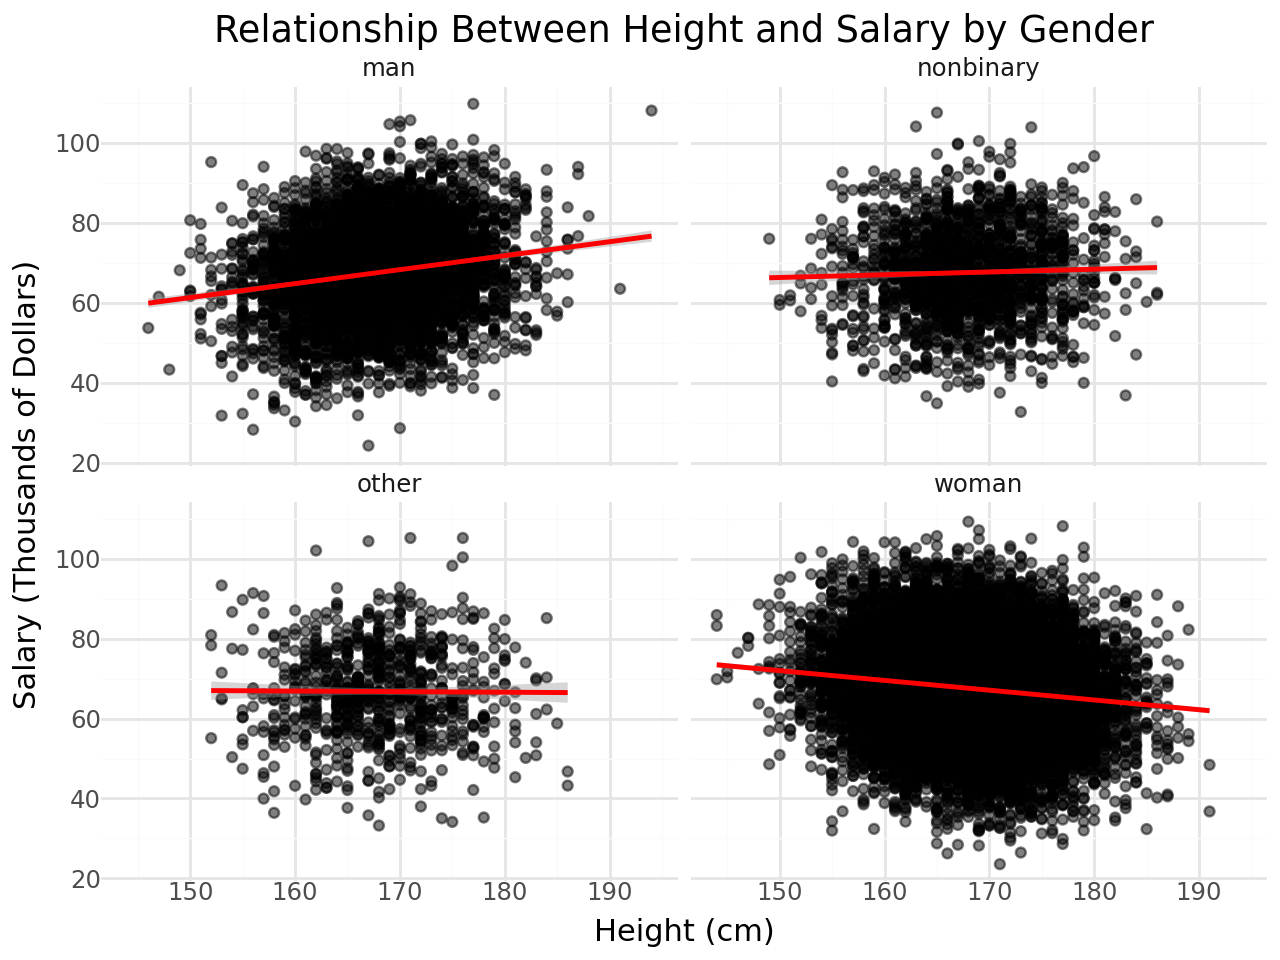

In [ ]:
(ggplot(boutique, aes(x = "height_cm", y = "salary_self_report_in_k",))
+ geom_point(alpha = 0.5)
+ labs(title = "Relationship Between Height and Salary by Gender",
       x = "Height (cm)",
       y = "Salary (Thousands of Dollars)")
+ stat_smooth(method = "lm", color = "red")
+ facet_wrap("~gender")
+ theme_minimal())

The second set of graphs breaks down the relationship between salary and height by gender, and the trends vary across the different groups. For men, the red trend line slopes upward slightly, indicating a small positive relationship between height and salary; taller men tend to have higher salaries. In contrast, for women, the red line slopes downward, showing that taller women tend to have slightly lower salaries. For nonbinary individuals and those classified as "other," the red lines are nearly flat, which means there is no noticeable relationship between height and salary for these groups. These gender-based differences suggest that while height may influence salary for men and women, it does not have the same effect across all genders. Overall, the relationship between salary and height is weak and varies by gender.